# Operator

In [2]:
# [collapse: code] Colab Setup (Install Dependencies)

# Only run this if we are in Google Colab
if 'google.colab' in str(get_ipython()):
    print("Installing dependencies from pyproject.toml...")
    # This installs the repo itself (and its dependencies)
    !apt-get install gmsh 
    !apt-get install -qq xvfb libgl1-mesa-glx
    !pip install pyvista -qq
    !pip install -q "git+https://github.com/smec-ethz/tatva-docs.git"    
    print("Installation complete!")

## How to create an energy functional?

In `tatva`, we define any physical problem as an energy functional $\Psi$ and then use `JAX` based differentiation to construct residual operator or tangent stiffness operator. 

[`Operator`](api/tatva.md#operator) module is the core of `tatva`. This is the functionality you would use always to build a energy functional. `Operator` module takes a mesh (or sub-mesh) with an element type such as [`tatva.element.Tri3`](api/tatva.md#elements) or [`tatva.element.Quad4`](api/tatva.md#elements) and allows one to

- Interpolate nodal values at quadrature points using `op.eval`
- Take gradient of nodal values at quadrature points using `op.grad`
- Integrate quadrature values over the domain using `op.integrate`

!!! tip
    
    To build any problem or more specifically any energy functional, all we need are these **three functions** and how to handle `jax.numpy` arrays. 


## How to define `Operator`

To create an [`Operator`](api/tatva.md#operator) we need three quantities, a mesh, an element type and batch size 

```python
op = Operator(mesh, element_type, batch_size)
```

The first two arguments are the mesh and the elemetn type.

!!! info "Mesh and Elements in `tatva`"

    In `tatva` the [`Mesh`](api/tatva.md#mesh) object is a utitlity that contains the coordinates of the node and the connectivity as `numpy` arrays or as `jax.numpy` arrays. Apart from this `Mesh` class has no extra functionalities. We do provide a few functions to quickly generate very simple meshes such `Mesh.unit_square` or `Mesh.Rectangle` for quick testing. We expect users to create their own meshes using standard softwares such as `GMSH` and then define the mesh object.

    ```python
    mesh = Mesh(coords, connectivity)
    ```

    For [`element`](api/tatva.md#elements) types, currently `tatva` provides H$^1$ finite elements such as `Line2`, `Tri3`, `Quad4`, `Tetrahedron4` and `Hexahedron8`. But one easily define there own elements as shown in some of the examples.


The last argument that `Operator` class take is the `batch_size`. This controls how many elements will be processed together simultaneously. 

!!! info "Batch size for computational efficiency"

    If the `batch_size` is equal to **total number of elements** than all the elements will be processed (for `op.grad`, `op.integrate` or `op.eval`) simulatenously using `jax.lax.map`. If the `batch_size` is **1 then it will process elements one after other**. Fixing the `batch_size` allows you to control the computaitonal speed and the memory requirements. 

    By default `Operator` has `batch_size` equal to total number of elements. But when the mesh is versy large then it always efficient to set a value for `batch_size`.


## Getiing started with `Operator`

For demonstration of the `Operator` class, we define a unit square domain with a triangular mesh. For ease, `tatva` provides a simple function `Mesh.unit_square` from `tatva.Mesh` module to generate square domain with a triangular mesh.



In [3]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
import jax.numpy as jnp
from tatva import Mesh

mesh = Mesh.unit_square(n_x=1, n_y=1,  type="triangle", dim=2)
print("Coordinates of the nodes in the mesh: ", mesh.coords)
print("Connectivity of the elements in the mesh: ", mesh.elements)

Coordinates of the nodes in the mesh:  [[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
Connectivity of the elements in the mesh:  [[0 2 3]
 [0 3 1]]


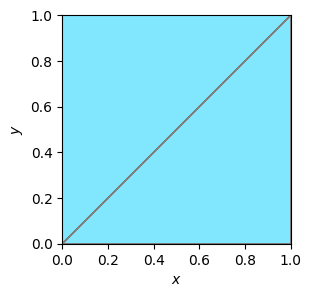

In [4]:
# [Collapse: code] Visualize the mesh

import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3), layout="constrained")
ax = plt.axes()
ax.tripcolor(
    *mesh.coords.T,
    mesh.elements,
    color="gray",
    lw=0.1,
    facecolors=jnp.ones(mesh.elements.shape[0]),
    cmap="managua_r",
)
ax.set_aspect("equal")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.margins(0.0, 0.0)
plt.show()


Let us define the `Operator`. We use the default `batch_size`.

In [5]:
from tatva import Operator, element

tri = element.Tri3()
op = Operator(mesh, tri)

## Evaluation at quadrature points

!!! note
    
    `op.eval`: Interpolate nodal values at quadrature points.


We can use the `op` to evaluate nodal values at the quadrature points. The function `op.eval` takes the nodal values and return the values at the quadrature points. The shape of the input array to the `Operator.eval` method is `(n_nodes, n_dofs)`. And the shape of the output array is `(n_elements, n_quadrature_points, n_dofs)`.

For example, below we evaluate the coordinate values of the mesh at the quadrature points. This basically means mapping the parameterized quadrature points ($\in [-1, 1]^2$) to the physical space. 

In [6]:
quad_points_in_physical_space = op.eval(mesh.coords)

print(quad_points_in_physical_space)
print("Shape of the quadrature points in physical space: ", quad_points_in_physical_space.shape)

[[[0.66666667 0.33333333]]

 [[0.33333333 0.66666667]]]
Shape of the quadrature points in physical space:  (2, 1, 2)


In the above example, the shape of the output array is `(2, 1, 2)` because we have 2 elements in the mesh and 1 quadrature point in each element. And each element has 2 degrees of freedom (2 displacement components). To test whether the output is correct, we can plot the quadrature points in the physical space. Below, we plot the mesh and the quadrature points in the physical space.

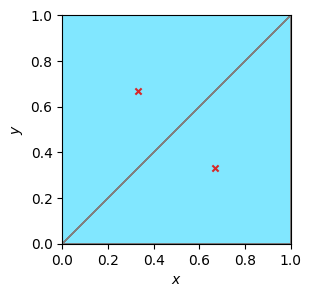

In [7]:
# [Collapse: code] Visualize the quadrature points in physical space

quad_points_in_physical_space = quad_points_in_physical_space.squeeze()

plt.figure(figsize=(3, 3), layout="constrained")
ax = plt.axes()
ax.tripcolor(
    *mesh.coords.T,
    mesh.elements,
    color="gray",
    lw=0.1,
    facecolors=jnp.ones(mesh.elements.shape[0]),
    cmap="managua_r",
)
ax.scatter(
    quad_points_in_physical_space[:, 0],
    quad_points_in_physical_space[:, 1],
    c='tab:red',
    s=20,
    marker="x",
)
ax.set_aspect("equal")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.margins(0.0, 0.0)

## Gradients of nodal values


!!! note

    `op.grad`: Evaluate the gradient of nodal values at quadrature points.


For most physical problems,  we often need to evaluate the gradient of the nodal values at the quadrature points. For example, in the case of linear elasticity, we need to evaluate the gradient of the displacement field at the quadrature points to compute the strain tensor.  The strain tensor is given as 

$$
\boldsymbol{\epsilon}(x) = \dfrac{1}{2} \left( \nabla \boldsymbol{u}(x) + \nabla \boldsymbol{u}(x)^T \right)
$$

The `Operator` class provides a method `grad` that can be used to evaluate the gradient of the nodal values at the quadrature points.



Below, we will see how to use the `Operator.grad` method to evaluate the gradient of the nodal values at the quadrature points. To do this, we can simply pass our nodal values (in this case, the coordinate values) to the `Operator.grad` function and it will return the gradient of the nodal values at the quadrature points. 

!!! note

    Remember to pass the nodal values to the `Operator.grad` function, it must be arranged in the shape `(n_nodes, n_dofs)`.


In [8]:
op.grad(mesh.coords)

Array([[[[1., 0.],
         [0., 1.]]],


       [[[1., 0.],
         [0., 1.]]]], dtype=float64)

As a sanity check, we can see that the gradient is an identity matrix since the gradient $\partial x / \partial x = 1$ and $\partial y / \partial y = 1$ and all other gradients are zero.

!!! Info
    The shape of the vector returned by the `Operator.grad` function is `(n_elements, n_quadrature_points,  n_dofs, n_dofs)`. The first dimension is the number of elements, the second dimension is the number of quadrature points, the third dimension is the number of degrees of freedom, and the fourth dimension is the number of degrees of freedom.

    For a triangular element, the shape will be `(n_elements, 1, 2, 2)`. For a quadrilateral element with 4 quadrature points, the shape will be `(n_elements, 4, 2, 2)`.



## Integrating a function over the domain


!!! note
    `op.integrate`: Integrate an array over the domain spanned by the operator's mesh.

To create a energy functional we need to integrate quadrature values over the domain. For example, **integrating the strain energy density** over the domain to get the total strain energy.

$$
\Psi_\text{e}(u) = \int_{\Omega} \frac{1}{2} \sigma : \epsilon \, dV
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor evaluated at the quadrature points. A finite element method way of integrating this over a discretized domain is to approximate the integral as a sum of integrals over the elements in the domain.

$$
\Psi_\text{e}(u) \approx \sum_{e \in \mathcal{E}} \sum_{\xi_1, \xi_2 \in \mathcal{Q}} \frac{1}{2} \sigma(\xi_1, \xi_2) : \epsilon(\xi_1, \xi_2) \, \text{det}\mathbf{J} \, w(\xi_1, \xi_2)
$$

where $\mathcal{E}$ is the set of all elements in the domain, $\mathcal{Q}$ is the set of all quadrature points in the domain, $J(\xi)$ is the Jacobian of the transformation from the reference element to the physical element, and $\sigma(\xi)$ and $\epsilon(\xi)$ are the stress and strain tensors evaluated at the quadrature point $\xi$.

The `integrate` method of the `Operator` class takes values at quadrature points and returns the integral of the function over the domain.

For example, we want to integrate a function $f(x, y)$ over the square domain. We assume that the function is constant and equal to 1.0. 

$$
f(x, y) = 1.
$$

We will first define nodal values of the function. Since the function is constant, we can simply define the nodal values as an array of shape `n_nodes`.

In [9]:
f_nodal = jnp.full(mesh.coords.shape[0], fill_value=1.0)

We can then evaluate the function at the quadrature points using the `op.eval` method.

In [10]:
f_at_quad = op.eval(f_nodal)

And then can pass it to the `integrate` method.

In [11]:
op.integrate(f_at_quad)

Array(1., dtype=float64)

If you will notice the above integral is equal to `1` which also happens to be the area of the domain. This is not a coincidence. The integral of a constant function = 1 over a domain is the area of the domain. So this is a sanity check.


!!! tip

    `op.integrate` can also take nodal values and even a scalar value. Below, we pass scalar value 1 to `op.integrate` and also the nodal_values.


In [12]:
op.integrate(1)

Array(1., dtype=float64)

In [13]:
op.integrate(f_nodal)

Array(1., dtype=float64)